# Assignment 9

Welcome to the assignment for week 9.

## Task 9: YOLO - You Only Look Once

This week, we want you to implement the core YOLO algorithm for object detection. Feel free to stay close to the lecture and/or use information from the web. You will pass the assignment, if we see the main YOLO algorithm characteristics in your code. A well performing model is not the only factor for passing the assignment.

### Task 9.1 Prepare Multi-Object Detection Dataset (COCO)

* Load and prepare the COCO dataset - for example using the PyTorch library directly: https://pytorch.org/vision/0.19/generated/torchvision.datasets.CocoDetection.html
* Prepare the sample and target for later use and show some samples. **(RESULT)**

In [1]:
import os
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from pycocotools.coco import COCO
from PIL import Image as PILImage
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as T

import torch.nn as nn
import torch.optim as optim
from typing import List, Tuple

class COCODatasetForYOLO(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images
            annotation_file (string): Path to COCO annotation file
            transform (callable, optional): Optional transform to be applied on a sample
        """
        
        self.root_dir = root_dir
        self.coco = COCO(annotation_file)
        self.transform = transform if transform else transforms.ToTensor()
        
        # Get all image IDs
        self.image_ids = list(self.coco.imgs.keys())
        
        # Get all category IDs and create a mapping to continuous indices
        self.categories = self.coco.loadCats(self.coco.getCatIds())
        self.category_to_idx = {cat['id']: idx for idx, cat in enumerate(self.categories)}
        
        # Add print statements to debug class mapping
        self.categories = self.coco.loadCats(self.coco.getCatIds())
        # Print the first few categories and their mapping
        for cat_id, idx in list(self.category_to_idx.items())[:10]:
            cat_name = next(cat['name'] for cat in self.categories if cat['id'] == cat_id)
            print(f"COCO ID: {cat_id}, Name: {cat_name}, Index: {idx}")
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        
        img_id = self.image_ids[idx]
    
        # Load image
        img_info = self.coco.loadImgs(img_id)[0]
        image_path = os.path.join(self.root_dir, img_info['file_name'])
        image = PILImage.open(image_path).convert('RGB')  # Changed from Image.open to PILImage.open
        
        # Get original image dimensions
        width = img_info['width']
        height = img_info['height']
        
        # Get annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)
        
        # Convert annotations to YOLO format
        boxes = []
        labels = []
        
        for ann in annotations:
            # Skip crowd annotations
            if ann['iscrowd']:
                continue
                
            # Get bbox coordinates
            x, y, w, h = ann['bbox']
            
            # COCO Format:
            # x, y: Top left corner coordinates, all values in absolute pixels
            
            # Convert to YOLO format (normalized centroids)
            x_center = (x + w/2) / width
            y_center = (y + h/2) / height
            w = w / width
            h = h / height
            
            # YOLO format:
            # x_center, y_center: Normalized x and y coordinates of bbox center
            
            # Clip values to [0, 1]
            x_center = min(max(x_center, 0), 1)
            y_center = min(max(y_center, 0), 1)
            w = min(max(w, 0), 1)
            h = min(max(h, 0), 1)
            
            boxes.append([x_center, y_center, w, h])
            # converts COCO's original category IDs into continuous indices that the model can use
            labels.append(self.category_to_idx[ann['category_id']])
        
        # Convert to tensor
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)
        
        # Apply transforms to image
        image = self.transform(image)
        
        return {
            'image': image,
            'boxes': boxes,
            'labels': labels,
            'image_id': img_id
        }

    def get_category_names(self):
        """Returns a list of category names in order of their indices"""
        return [self.categories[i]['name'] for i in range(len(self.categories))]

# Example usage and transformations
def get_coco_dataloader(root_dir, annotation_file, batch_size=16, num_workers=4):
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((416, 416)),  # YOLO typically uses multiples of 32
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create dataset
    dataset = COCODatasetForYOLO(
        root_dir=root_dir,
        annotation_file=annotation_file,
        transform=transform
    )
    
    # Create dataloader
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn  # Custom collate function to handle variable size boxes
    )
    
    return dataloader, dataset

# PyTorch's default collate function expects all tensors to have the same shape so it can stack them into a single batch tensor. 
# However, this won't work with variable numbers of objects per image.
# 1. Stacking the images normally (since they all have the same dimensions)
# 2. Keeping boxes and labels as separate lists for each image
def collate_fn(batch):
    """Custom collate function to handle variable number of boxes per image"""
    images = []
    boxes = []
    labels = []
    image_ids = []
    
    for b in batch:
        images.append(b['image'])
        boxes.append(b['boxes'])
        labels.append(b['labels'])
        image_ids.append(b['image_id'])
        
    images = torch.stack(images, dim=0)
    
    return {
        'images': images,
        'boxes': boxes,
        'labels': labels,
        'image_ids': image_ids
    }

In [2]:
# # Training images (118K images, 18GB)
# !wget -P ./data/coco http://images.cocodataset.org/zips/train2017.zip
# # Validation images (5K images, 1GB)
# !wget -P ./data/coco http://images.cocodataset.org/zips/val2017.zip
# # Test images (41K images, 6GB)
# !wget -P ./data/coco http://images.cocodataset.org/zips/test2017.zip
# # Training/Validation annotations (241MB)
# !wget -P ./data/coco http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# # Extract images
# !unzip ./data/coco/train2017.zip -d ./data/coco/
# !unzip ./data/coco/val2017.zip -d ./data/coco/
# !unzip ./data/coco/test2017.zip -d ./data/coco/
# # Extract annotations
# !unzip ./data/coco/annotations_trainval2017.zip -d ./data/coco/


loading annotations into memory...
Done (t=5.68s)
creating index...
index created!
COCO ID: 1, Name: person, Index: 0
COCO ID: 2, Name: bicycle, Index: 1
COCO ID: 3, Name: car, Index: 2
COCO ID: 4, Name: motorcycle, Index: 3
COCO ID: 5, Name: airplane, Index: 4
COCO ID: 6, Name: bus, Index: 5
COCO ID: 7, Name: train, Index: 6
COCO ID: 8, Name: truck, Index: 7
COCO ID: 9, Name: boat, Index: 8
COCO ID: 10, Name: traffic light, Index: 9


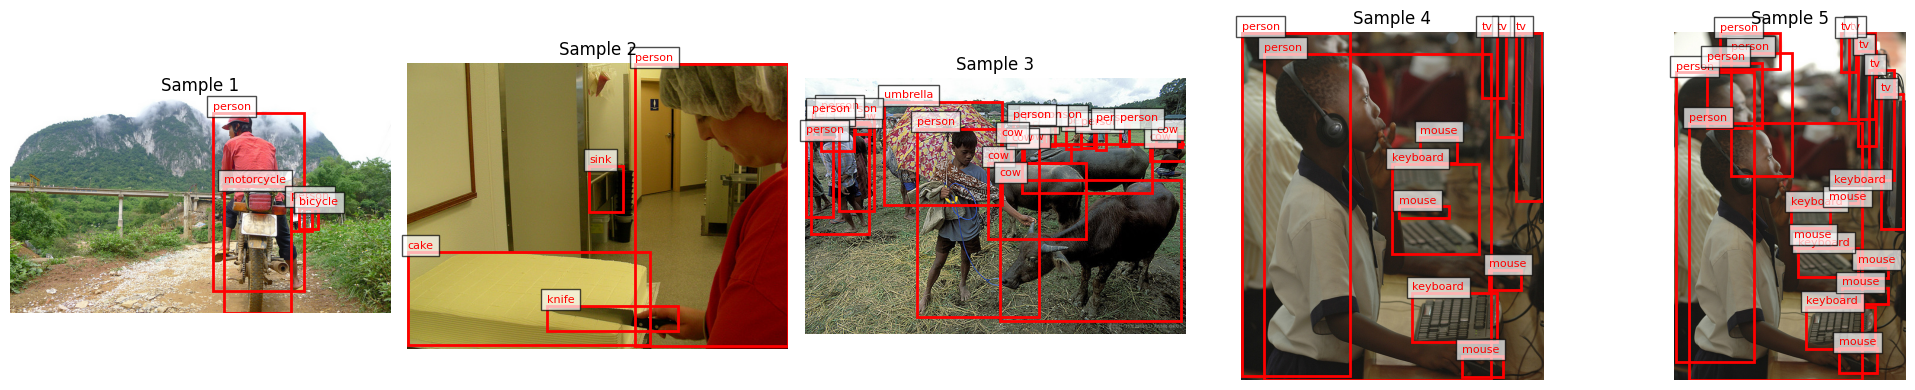

In [3]:
def visualize_dataset_samples(dataset, num_samples=5, figsize=(20, 4)):
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)
    
    for i in range(num_samples):
        sample = dataset[i]
        image = sample['image']  # Shape: (C, H, W)
        boxes = sample['boxes']
        labels = sample['labels']
        
        # Correctly denormalize the image
        # image = denormalize_image(image)
        
        # Convert to numpy and transpose to (H, W, C)
        image = image.permute(1, 2, 0).numpy()
        
        # Clip values to valid image range
        image = np.clip(image, 0, 1)
        
        # Plot image
        axes[i].imshow(image)
        
        # Convert YOLO format boxes back to pixel coordinates
        height, width = image.shape[:2]
        for box, label in zip(boxes, labels):
            # Convert from center format to corner format
            x_center, y_center, w, h = box.numpy()
            x = (x_center - w/2) * width
            y = (y_center - h/2) * height
            w = w * width
            h = h * height
            
            # Create rectangle patch
            rect = patches.Rectangle(
                (x, y), w, h,
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            axes[i].add_patch(rect)
            
            # Add label
            category_name = dataset.get_category_names()[label]
            axes[i].text(
                x, y-5,
                category_name,
                color='red',
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7)
            )
        
        axes[i].axis('off')
        axes[i].set_title(f'Sample {i+1}')
    
    plt.tight_layout()
    plt.show()

root_dir = './data/coco/train2017'
annotation_file = './data/coco/annotations/instances_train2017.json'

# Create dataset
dataset = COCODatasetForYOLO(
    root_dir=root_dir,
    annotation_file=annotation_file
)

# Visualize samples
visualize_dataset_samples(dataset, num_samples=5)

### Task 9.2 Build the YOLO pipeline

* Setup a model class for your model. **(RESULT)**
* Build a training loop and the necessary additional functions for training. **(RESULT)**
* Run at least a few training iterations on your machine. **(RESULT)**

In [4]:
from IPython.display import Image
Image(url= "https://www.researchgate.net/publication/349348933/figure/fig3/AS:991958927413250@1613512846560/The-architecture-of-YOLOv3-The-red-box-part-represents-Darknet53-without-fully-connected.ppm")


In [5]:
## Architecture:
# Darknet-53 backbone (simplified)
# Three detection scales for different sized objects
# Residual blocks for better feature extraction
# Anchor-based detection


##Loss Components:
# Box coordinate loss (MSE)
# Object confidence loss (BCE)
# Class prediction loss (BCE)


## Training loop with:
# Adam optimizer
# Checkpoint saving
# Progress tracking
# GPU support

class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, 
                 stride: int = 1, padding: int = 0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, 
                            stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        
    def forward(self, x):
        return self.leaky(self.bn(self.conv(x)))

class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels//2, 1),
            ConvBlock(channels//2, channels, 3, padding=1)
        )
        
    def forward(self, x):
        return x + self.block(x)

class YOLOv3(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        
        print(f"Initializing YOLOv3 with {num_classes} classes")
        # Verify output dimensions
        output_channels = 3 * (5 + num_classes)  # Should be 255 for COCO
        print(f"Output channels per detection: {output_channels}")
        
        self.num_classes = num_classes
        self.num_anchors = 3
        
        # TODO: Define anchors for COCO
        self.anchors = torch.tensor([
            [(116, 90), (156, 198), (373, 326)],  # Large objects
            [(30, 61), (62, 45), (59, 119)],      # Medium objects
            [(10, 13), (16, 30), (33, 23)]        # Small objects
        ])
        
        # Darknet-53 backbone
        self.backbone = nn.Sequential(
            ConvBlock(3, 32, 3, padding=1),
            ConvBlock(32, 64, 3, stride=2, padding=1),
            *[ResidualBlock(64) for _ in range(1)],
            ConvBlock(64, 128, 3, stride=2, padding=1),
            *[ResidualBlock(128) for _ in range(2)],
            ConvBlock(128, 256, 3, stride=2, padding=1),
            *[ResidualBlock(256) for _ in range(8)],
            ConvBlock(256, 512, 3, stride=2, padding=1),
            *[ResidualBlock(512) for _ in range(8)],
            ConvBlock(512, 1024, 3, stride=2, padding=1),
            *[ResidualBlock(1024) for _ in range(4)]
        )
        
        # Detection layer 1 (1024 -> output)
        self.detect1 = nn.Sequential(
            ConvBlock(1024, 512, 1),
            ConvBlock(512, 1024, 3, padding=1),
            ConvBlock(1024, 512, 1),
            ConvBlock(512, 1024, 3, padding=1),
            nn.Conv2d(1024, self.num_anchors * (5 + self.num_classes), 1)
        )
        
        # Upsampling path 1 (1024 -> 512)
        self.up1_conv = ConvBlock(1024, 512, 1)
        self.up1_upsample = nn.Upsample(scale_factor=2)
        
        # Detection layer 2 (1024 -> output)
        self.detect2 = nn.Sequential(
            ConvBlock(1024, 512, 1),  # 1024 = 512 + 512 (concatenated features)
            ConvBlock(512, 1024, 3, padding=1),
            ConvBlock(1024, 512, 1),
            ConvBlock(512, 1024, 3, padding=1),
            nn.Conv2d(1024, self.num_anchors * (5 + self.num_classes), 1)
        )
        
        # Upsampling path 2 (1024 -> 256)
        self.up2_conv = ConvBlock(1024, 256, 1)
        self.up2_upsample = nn.Upsample(scale_factor=2)
        
        # Detection layer 3 (512 -> output)
        self.detect3 = nn.Sequential(
            ConvBlock(512, 256, 1),  # 512 = 256 + 256 (concatenated features)
            ConvBlock(256, 512, 3, padding=1),
            ConvBlock(512, 256, 1),
            ConvBlock(256, 512, 3, padding=1),
            nn.Conv2d(512, self.num_anchors * (5 + self.num_classes), 1)
        )
        
    def forward(self, x):
        # Store intermediate outputs for skip connections
        skip_connections = []
        
        # Backbone with skip connections
        for i, layer in enumerate(self.backbone):
            x = layer(x)
            if i == 14:  # After layer producing 256 channels
                skip_connections.append(x)
            elif i == 23:  # After layer producing 512 channels
                skip_connections.append(x)
        
        # First detection branch (13x13 grid)
        detect1 = self.detect1(x)
        
        # First upsampling path
        up = self.up1_conv(x)            # 1024 -> 512 channels
        up = self.up1_upsample(up)       # 13x13 -> 26x26
        x = torch.cat([up, skip_connections[1]], dim=1)  # 512 + 512 = 1024 channels
        
        # Second detection branch (26x26 grid)
        detect2 = self.detect2(x)
        
        # Second upsampling path
        up = self.up2_conv(x)            # 1024 -> 256 channels
        up = self.up2_upsample(up)       # 26x26 -> 52x52
        x = torch.cat([up, skip_connections[0]], dim=1)  # 256 + 256 = 512 channels
        
        # Third detection branch (52x52 grid)
        detect3 = self.detect3(x)
        
        return [detect1, detect2, detect3]

class YOLOLoss(nn.Module):
    def __init__(self, anchors: torch.Tensor, num_classes: int):
        super().__init__()
        # Store anchor boxes (predefined box templates) and number of classes
        self.anchors = anchors              # Shape: (3, 3, 2) - 3 scales, 3 anchors per scale, (w,h) per anchor
        self.num_classes = num_classes      # Number of object classes (80 for COCO)
        # Loss functions
        self.mse = nn.MSELoss()             # For box coordinate regression
        self.bce = nn.BCEWithLogitsLoss()   # For objectness and class prediction (includes sigmoid)
        # Fixed loss weights
        self.lambda_coord = 5               # Weight for box coordinate loss (higher because box accuracy is important)
        self.lambda_noobj = 0.5             # Weight for no-object confidence (lower because most cells don't have objects) 

    def forward(self, predictions: List[torch.Tensor], targets: dict):
        """
        Process YOLO predictions and calculate loss
        predictions: List of 3 tensors for different scales (13x13, 26x26, 52x52)
        targets: Dictionary with ground truth boxes and labels for each image in batch
        """
        
        # # Debug output for class predictions
        # print("Unique class IDs in targets:", 
        #     [torch.unique(target['labels']) for target in targets])
        # print("Class scores range:", 
        #     torch.sigmoid(predictions[0][..., 5:]).min().item(),
        #     torch.sigmoid(predictions[0][..., 5:]).max().item())
        
        # Setup for loss calculation
        device = predictions[0].device
        batch_size = predictions[0].size(0)
        total_loss = torch.tensor(0.0, device=device)

        # Process each scale prediction (13x13, 26x26, 52x52)
        for pred_idx, pred in enumerate(predictions):
            grid_size = pred.size(2)
            
            # Reshape predictions to (batch, 3 anchors, grid, grid, 85)
            # where 85 = 5 (box params) + 80 (class scores)
            pred = pred.view(batch_size, 3, 5 + self.num_classes, grid_size, grid_size)
            pred = pred.permute(0, 1, 3, 4, 2).contiguous()
            
            # Initialize target tensors for this scale
            obj_mask = torch.zeros((batch_size, 3, grid_size, grid_size), dtype=torch.bool, device=device)      # Marks cells with objects
            noobj_mask = torch.ones((batch_size, 3, grid_size, grid_size), dtype=torch.bool, device=device)     # Marks cells without objects
            box_target = torch.zeros((batch_size, 3, grid_size, grid_size, 4), device=device)                   # Target box coordinates
            class_target = torch.zeros((batch_size, 3, grid_size, grid_size, self.num_classes), device=device)  # Target class one-hot vectors
            
            # Process each image in batch
            for batch_idx in range(batch_size):
                target_boxes = targets['boxes'][batch_idx]      # Ground truth boxes for this image
                target_labels = targets['labels'][batch_idx]    # Ground truth labels for this image
                
                if len(target_boxes) == 0:  # Skip if no objects in this image
                    continue
                
                # Scale target boxes to grid size
                # grid_factor = grid_size / 416  # Assuming input size is 416x416
                # Works for normalized box coordinates [0, 1]
                target_boxes_grid = target_boxes.clone()
                target_boxes_grid[:, [0, 2]] *= grid_size  # scale x, width
                target_boxes_grid[:, [1, 3]] *= grid_size  # scale y, height
                
                # Process each ground truth box in this image
                for box_idx, (box, label) in enumerate(zip(target_boxes_grid, target_labels)):
                    # Find which grid cell this object belongs to
                    grid_x = int(box[0])    # Grid cell x-index
                    grid_y = int(box[1])    # Grid cell y-index
                    
                    # Skip if box center falls outside grid
                    if grid_x >= grid_size or grid_y >= grid_size:
                        continue
                        
                    # Find best matching anchor box for this ground truth box
                    anchor_ious = self.calculate_anchor_ious(box[2:4], 
                                                           self.anchors[pred_idx])
                    best_anchor_idx = anchor_ious.argmax()
                    
                    # Set target values for this object
                    obj_mask[batch_idx, best_anchor_idx, grid_y, grid_x] = True
                    noobj_mask[batch_idx, best_anchor_idx, grid_y, grid_x] = False
                    box_target[batch_idx, best_anchor_idx, grid_y, grid_x] = box
                    class_target[batch_idx, best_anchor_idx, grid_y, grid_x, label] = 1
            
            # Calculate individual loss components
            # 1. Box coordinate loss (MSE)
            pred_boxes = pred[..., :4][obj_mask]    # Predicted boxes where objects exist
            target_boxes = box_target[obj_mask]     # Target boxes where objects exist
            box_loss = self.mse(pred_boxes, target_boxes)
            
            # 2. Object confidence loss (BCE)
            pred_conf = pred[..., 4][obj_mask]      # Predicted objectness where objects exist
            conf_loss_obj = self.bce(pred_conf, torch.ones_like(pred_conf))
            
            # 3. No object confidence loss (BCE)
            pred_conf_noobj = pred[..., 4][noobj_mask]  # Predicted objectness where no objects exist
            conf_loss_noobj = self.bce(pred_conf_noobj, torch.zeros_like(pred_conf_noobj))
            
            # 4. Class prediction loss (BCE)
            pred_cls = pred[..., 5:][obj_mask]  # Predicted classes where objects exist
            target_cls = class_target[obj_mask] # Target classes where objects exist
            cls_loss = self.bce(pred_cls, target_cls)
            
            # Combine all loss components with their weights
            loss = (
                self.lambda_coord * box_loss +
                conf_loss_obj +
                self.lambda_noobj * conf_loss_noobj +
                cls_loss
            )
            total_loss += loss
        
        # Return average loss across all scales
        return total_loss / len(predictions)
    
    def calculate_anchor_ious(self, box_wh: torch.Tensor, anchors: torch.Tensor) -> torch.Tensor:
        """
        Calculate IoU (Intersection over Union) between a ground truth box and anchor boxes
        box_wh: Tensor of shape (2,) containing width and height of ground truth box
        anchors: Tensor of shape (num_anchors, 2) containing width and height of anchor boxes
        
        box_wh shape: (2,)          e.g., tensor([50, 30])     # width=50, height=30
        anchors shape: (3, 2)       e.g., tensor([[20, 30],    # anchor1: w=20, h=30
                                                [40, 40],      # anchor2: w=40, h=40
                                                [60, 50]])     # anchor3: w=60, h=50
        """
        box_wh = box_wh.unsqueeze(0)                            # Add dimension for broadcasting
        # box_wh becomes: shape (1, 2)
        # e.g., tensor([[50, 30]])
        anchors = torch.tensor(anchors, device=box_wh.device)
        
        
        # Calculate intersection areas
        min_wh = torch.min(box_wh, anchors)                 # Get overlapping width and height
        # min_wh shape: (3, 2)
        intersection = min_wh[..., 0] * min_wh[..., 1]      # Calculate intersection area
        # intersection shape: (3,)
        # e.g., tensor([600,    # 20 * 30
        #               1200,   # 40 * 30
        #               1500])  # 50 * 30
        
        # Calculate union areas
        box_area = box_wh[..., 0] * box_wh[..., 1]          # Area of ground truth box
        # box_area: scalar
        # e.g., tensor(1500)  # 50 * 30
        anchor_area = anchors[..., 0] * anchors[..., 1]     # Areas of anchor boxes
        # anchor_area shape: (3,)
        # e.g., tensor([600,    # 20 * 30
        #               1600,   # 40 * 40
        #               3000])  # 60 * 50
        union = box_area + anchor_area - intersection       # Union area using inclusion-exclusion
        # union shape: (3,)
        # e.g., tensor([1500,   # 1500 + 600 - 600
        #               1900,   # 1500 + 1600 - 1200
        #               3000])  # 1500 + 3000 - 1500
        
        return intersection / union                         #  IoU = intersection / union

def train_yolo(model: nn.Module, 
               train_loader: torch.utils.data.DataLoader,
               num_epochs: int,
               learning_rate: float = 0.001,
               device: str = 'cuda'):
    
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = YOLOLoss(model.anchors, model.num_classes).to(device)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch_idx, batch in enumerate(train_loader):
            images = batch['images'].to(device)
            targets = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                      for k, v in batch.items() if k != 'images'}
            
            # Forward pass
            predictions = model(images)
            loss = criterion(predictions, targets)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], "
                      f"Batch [{batch_idx}/{len(train_loader)}], "
                      f"Loss: {loss.item():.4f}")
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch}/{num_epochs}], Average Loss: {avg_loss:.4f}")
        
        # Save checkpoint
        if (epoch + 1) % 3 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, f'output/yolo_checkpoint_epoch_{epoch+1}.pth')

In [6]:
num_classes = 80  # COCO has 80 classes
model = YOLOv3(num_classes)

root_dir = './data/coco/train2017'
annotation_file = './data/coco/annotations/instances_train2017.json'

dataloader, dataset = get_coco_dataloader(
    root_dir=root_dir,
    annotation_file=annotation_file,
    batch_size=64
)

print(torch.cuda.is_available())

# train_yolo(
#     model=model,
#     train_loader=dataloader,
#     num_epochs=100,
#     learning_rate=0.001,
#     device='cuda:1' if torch.cuda.is_available() else 'cpu'
# )

Initializing YOLOv3 with 80 classes
Output channels per detection: 255


loading annotations into memory...
Done (t=5.65s)
creating index...
index created!
COCO ID: 1, Name: person, Index: 0
COCO ID: 2, Name: bicycle, Index: 1
COCO ID: 3, Name: car, Index: 2
COCO ID: 4, Name: motorcycle, Index: 3
COCO ID: 5, Name: airplane, Index: 4
COCO ID: 6, Name: bus, Index: 5
COCO ID: 7, Name: train, Index: 6
COCO ID: 8, Name: truck, Index: 7
COCO ID: 9, Name: boat, Index: 8
COCO ID: 10, Name: traffic light, Index: 9
True


### Task 9.3 Show your results

* Plot at least two detection results on COCO samples your model has not seen. **(RESULT)**

Initializing YOLOv3 with 80 classes
Output channels per detection: 255


/tmp/ipykernel_2203118/394581403.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded model from epoch 2


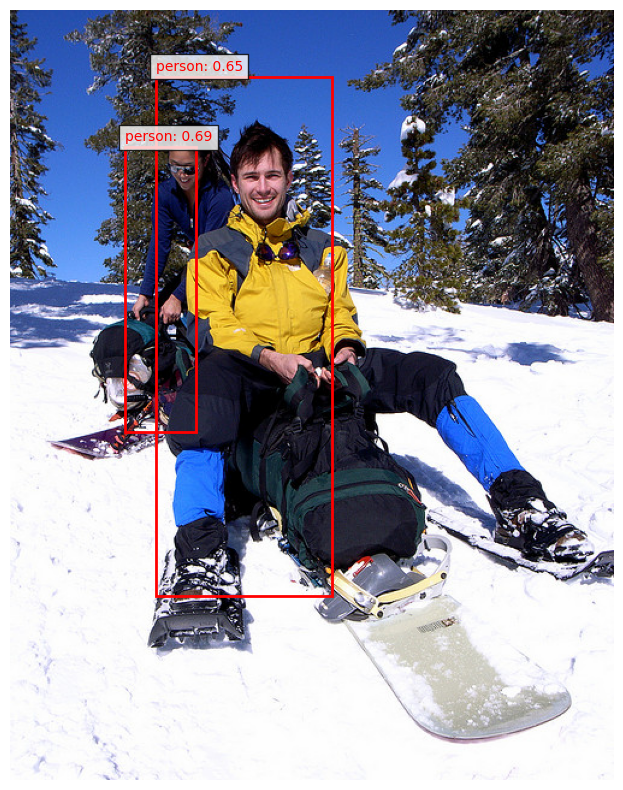

In [ ]:
def load_checkpoint(model, checkpoint_path, device):
    """Load a saved checkpoint into the model"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set to evaluation mode
    return model, checkpoint['epoch']

def process_predictions(predictions, confidence_threshold=0.25, nms_threshold=0.45):
    """
    Convert raw predictions to bounding boxes with NMS
    confidence_threshold: minimum objectness score
    nms_threshold: IoU threshold for NMS
    """
    
    # predictions format: List of 3 tensors for different scales
    # Each tensor shape: (batch_size, 255, grid_size, grid_size)
    # 255 = 3 * (5 + 80) = 3 anchors * (5 box values + 80 class scores)
    
    all_boxes = []
    all_scores = []
    all_class_ids = []
    
    # Process each scale separately (13x13, 26x26, 52x52)
    for pred in predictions:
        batch_size = pred.size(0)
        num_anchors = 3
        grid_size = pred.size(2)
        
        # Reshape from (batch_size, 255, grid, grid) to (batch_size, 3, 85, grid, grid)
        pred = pred.view(batch_size, num_anchors, -1, grid_size, grid_size)
        # Reorder dimensions to (batch_size, 3, grid, grid, 85)
        pred = pred.permute(0, 1, 3, 4, 2).contiguous()
        
        # Extract and process confidence scores
        conf = torch.sigmoid(pred[..., 4])          # Object confidence (objectness score)
        cls_scores = torch.sigmoid(pred[..., 5:])   # Class probabilities
        
        # Get highest scoring class and its score for each prediction
        class_scores, class_ids = cls_scores.max(dim=-1)
        
        # Final confidence score = objectness * class confidence
        scores = conf * class_scores
        
        # Keep only predictions above confidence threshold
        mask = scores > confidence_threshold
        
        # Apply mask to get filtered predictions
        boxes = pred[..., :4][mask]             # Get boxes that passed threshold
        filtered_scores = scores[mask]          # Get corresponding scores
        filtered_class_ids = class_ids[mask]    # Get corresponding class IDs
        
        # Convert from grid-relative to image coordinates
        boxes[..., [0,2]] /= grid_size  # x, width
        boxes[..., [1,3]] /= grid_size  # y, height
        
        # Store filtered predictions from this scale
        all_boxes.append(boxes)
        all_scores.append(filtered_scores)
        all_class_ids.append(filtered_class_ids)
    
    # Combine predictions from all scales if we have any detections
    if all_boxes:
        # Concatenate all scales' predictions
        boxes = torch.cat(all_boxes)
        scores = torch.cat(all_scores)
        class_ids = torch.cat(all_class_ids)
        
        # Prepare lists for NMS results
        final_boxes = []
        final_scores = []
        final_class_ids = []
        
        # Apply NMS separately for each class
        for class_id in torch.unique(class_ids):
            # Get mask for current class
            class_mask = class_ids == class_id
            
            if class_mask.any():
                # Get all boxes of this class
                class_boxes = boxes[class_mask]
                class_scores = scores[class_mask]
                
                # Apply NMS to remove overlapping boxes of same class
                keep_indices = nms(
                    boxes=class_boxes,
                    scores=class_scores,
                    iou_threshold=nms_threshold
                )
                
                # Store kept predictions
                final_boxes.append(class_boxes[keep_indices])
                final_scores.append(class_scores[keep_indices])
                final_class_ids.append(torch.full_like(keep_indices, class_id))
        
        # If we have any boxes after NMS
        if final_boxes:
            # Combine all kept predictions into single tensors
            return (torch.cat(final_boxes), 
                   torch.cat(final_scores), 
                   torch.cat(final_class_ids))
            
    # Return empty tensors if no detections
    return torch.tensor([]), torch.tensor([]), torch.tensor([])

def nms(boxes, scores, iou_threshold):
    """Non-Maximum Suppression"""
    if len(boxes) == 0:
        return torch.tensor([])
        
    # Convert to corners format for NMS
    x1 = boxes[:, 0] - boxes[:, 2]/2
    y1 = boxes[:, 1] - boxes[:, 3]/2
    x2 = boxes[:, 0] + boxes[:, 2]/2
    y2 = boxes[:, 1] + boxes[:, 3]/2
    
    # Compute areas
    areas = (x2 - x1) * (y2 - y1)
    
    # Sort by score
    _, order = scores.sort(descending=True)
    
    keep = []
    while order.numel() > 0:
        if order.numel() == 1:
            keep.append(order.item())
            break
            
        i = order[0]
        keep.append(i)
        
        # Compute IoU with remaining boxes
        xx1 = x1[order[1:]].clamp(min=x1[i])
        yy1 = y1[order[1:]].clamp(min=y1[i])
        xx2 = x2[order[1:]].clamp(max=x2[i])
        yy2 = y2[order[1:]].clamp(max=y2[i])
        
        w = (xx2 - xx1).clamp(min=0)
        h = (yy2 - yy1).clamp(min=0)
        inter = w * h
        
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        
        ids = (ovr <= iou_threshold).nonzero().squeeze()
        if ids.numel() == 0:
            break
        order = order[ids + 1]
    
    return torch.tensor(keep)

def visualize_predictions(image, boxes, scores, class_ids, class_names, figsize=(10,10)):
    """Visualize predictions on the image"""
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    
    # Check if any detections exist
    if len(boxes) == 0:
        print("No objects detected!")
        plt.axis('off')
        plt.show()
        return
    
    # Convert center format to corners for visualization
    boxes_corner = boxes.clone()
    boxes_corner[..., 0] = boxes[..., 0] - boxes[..., 2]/2  # x1 = cx - w/2
    boxes_corner[..., 1] = boxes[..., 1] - boxes[..., 3]/2  # y1 = cy - h/2
    boxes_corner[..., 2] = boxes[..., 2]  # width
    boxes_corner[..., 3] = boxes[..., 3]  # height
    
    # Plot each box
    for box, score, class_id in zip(boxes_corner, scores, class_ids):
        x, y, w, h = box.cpu().numpy()
        x *= image.width
        y *= image.height
        w *= image.width
        h *= image.height
        
        # Create rectangle patch
        rect = patches.Rectangle((x, y), w, h, linewidth=2, 
                               edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # Add label
        class_name = class_names[int(class_id)]
        label = f'{class_name}: {score:.2f}'
        ax.text(x, y-5, label, color='red',
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.axis('off')
    plt.show()

def test_model(model_path, image_path, class_names, confidence_threshold, nms_threshold, device='cuda:1'):
    """Test YOLO model on a single image"""
    # Load model
    model = YOLOv3(num_classes=len(class_names))
    model, epoch = load_checkpoint(model, model_path, device)
    model = model.to(device)
    print(f"Loaded model from epoch {epoch}")
    
    # Prepare image
    transform = transforms.Compose([
        transforms.Resize((416, 416)),                         # YOLO expects 416x416 input
        transforms.ToTensor(),                              # Convert to tensor and normalize to [0, 1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406],    # ImageNet normalization
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Load and transform image
    image = PILImage.open(image_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0).to(device)   # Add batch dimension
    
    # Get predictions
    with torch.no_grad():
        predictions = model(img_tensor)
    
    # Process predictions
    boxes, scores, class_ids = process_predictions(predictions, confidence_threshold=confidence_threshold, nms_threshold=nms_threshold)
    
    # Visualize results
    visualize_predictions(image, boxes, scores, class_ids, class_names)
    
    return boxes, scores, class_ids


# All 80 COCO classes
class_names = [
'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 
'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 
'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 
'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 
'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 
'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 
'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 
'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 
'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 
'hair drier', 'toothbrush'
]
    
# Test the model
model_path = "output/yolo_checkpoint_epoch_3.pth"
image_path = "data/coco/test2017/000000193419.jpg"


boxes, scores, class_ids = test_model(
    model_path=model_path,
    image_path=image_path,
    class_names=class_names,
    confidence_threshold=0.6,  # Increase this to get fewer detections
    nms_threshold=0.4        # Decrease this to remove more overlapping boxes
)

## Congratz, you made it! :)